<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [ ]:
import random
import numpy as np
import scipy as sp
import pickle
import cv2

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf

from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Eager mode: True
Found GPU at: /device:GPU:0


In [ ]:
def show_prediction(image, label, prediction):
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(image.reshape(28, 28), cmap='Greys')
  plt.title("Prediction: %s / Truth: %s" % (np.argmax(prediction), label))
  plt.show()

In [ ]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    height_zoom = size[1] / cam.shape[0]
    width_zoom = size[0] / cam.shape[1]
    heatmap = sp.ndimage.zoom(cam, (height_zoom, width_zoom), order=2)
 
  return heatmap

In [ ]:
def show_heatmap(img, cam, size, resize=True, title=None):
  img = img.reshape(size[0], size[1])
  heatmap = get_heatmap(cam, size, resize)

  # plot
  plt.figure(facecolor='white')
  ax = plt.gca()
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  plt.imshow(img, alpha=0.5, cmap='Greys')
  plt.imshow(heatmap, cmap='jet', alpha=0.5)
  
  if title is not None:
    plt.title(title)
  
  plt.show()  

In [ ]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [ ]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [ ]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [ ]:
def get_prediction(model, test, idx=-1):
  if idx < 0:
    idx = random.randint(0, len(test[0]))

  image = test[0][idx]
  label = np.argmax(test[1][idx])
  prediction = model.predict(np.expand_dims(image, 0))

  return image, label, prediction, idx

In [ ]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

#MNIST

In [ ]:
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(10, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Epoch 1/15
422/422 [==============================] - 9s 6ms/step - loss: 1.0055 - accuracy: 0.6708 - val_loss: 0.1288 - val_accuracy: 0.9628
Epoch 2/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1792 - accuracy: 0.9454 - val_loss: 0.0793 - val_accuracy: 0.9767
Epoch 3/15
422/422 [==============================] - 2s 5ms/step - loss: 0.1286 - accuracy: 0.9592 - val_loss: 0.0733 - val_accuracy: 0.9803
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0996 - accuracy: 0.9692 - val_loss: 0.0546 - val_accuracy: 0.9847
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0826 - accuracy: 0.9750 - val_loss: 0.0450 - val_accuracy: 0.9877
Epoch 6/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0699 - accuracy: 0.9784 - val_loss: 0.0373 - val_accuracy: 0.9895
Epoch 7/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0629 - accuracy: 0.9801 - val_loss: 0.0454 - val_accuracy: 0.9857
Epoch 

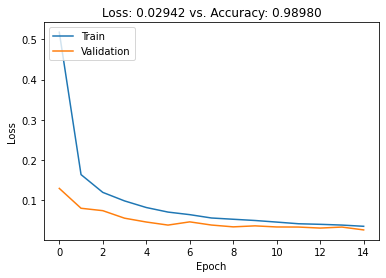

In [ ]:
model_mnist = create_mnist_model("gap_shallow", (28, 28, 1), 10, mnist_train)

# model_mnist, history_mnist = load_model("gap_shallow")
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
# save_model(model_mnist, history_mnist, "gap_shallow")

model_mnist.summary()
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)

plot_model_score(score_mnist, history_mnist.history)

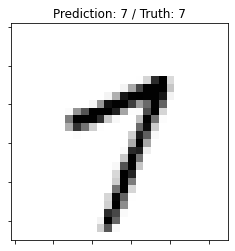

In [ ]:
image, label, prediction, _ = get_prediction(model_mnist, mnist_test)
show_prediction(image, label, prediction)

#GEO

In [ ]:
def get_geo_dataset():
  path = tf.keras.utils.get_file("geocam2", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz")
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [ ]:
geo_train, geo_test = get_geo_dataset()
geo_train, geo_test = format_dataset(3, geo_train, geo_test)

def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
       
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.3),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
          layers.GlobalAveragePooling2D(),
          
          layers.Dense(num_classes, activation="softmax"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

(28, 28)
2
x_train shape: (2100, 28, 28, 1)
2100 train samples
900 test samples


Epoch 1/15
15/15 [==============================] - 1s 34ms/step - loss: 1.0771 - accuracy: 0.3296 - val_loss: 1.0033 - val_accuracy: 0.3095
Epoch 2/15
15/15 [==============================] - 0s 14ms/step - loss: 0.9775 - accuracy: 0.3896 - val_loss: 0.7555 - val_accuracy: 0.8524
Epoch 3/15
15/15 [==============================] - 0s 14ms/step - loss: 0.6386 - accuracy: 0.9272 - val_loss: 0.2501 - val_accuracy: 0.9524
Epoch 4/15
15/15 [==============================] - 0s 14ms/step - loss: 0.2003 - accuracy: 0.9568 - val_loss: 0.1186 - val_accuracy: 0.9810
Epoch 5/15
15/15 [==============================] - 0s 15ms/step - loss: 0.0873 - accuracy: 0.9887 - val_loss: 0.0622 - val_accuracy: 0.9810
Epoch 6/15
15/15 [==============================] - 0s 14ms/step - loss: 0.0497 - accuracy: 0.9917 - val_loss: 0.0357 - val_accuracy: 0.9952
Epoch 7/15
15/15 [==============================] - 0s 14ms/step - loss: 0.0320 - accuracy: 0.9945 - val_loss: 0.0311 - val_accuracy: 0.9952
Epoch 8/15
15

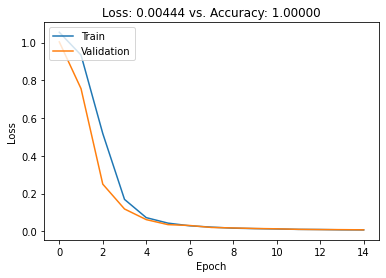

In [ ]:
model_geo = create_geo_model("geocam", (28, 28, 1), 3)
# model_geo, history_geo = load_model("geo")

history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.1)
# save_model(model_geo, history_geo, "geo")

model_geo.summary()
score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)

plot_model_score(score_geo, history_geo.history)

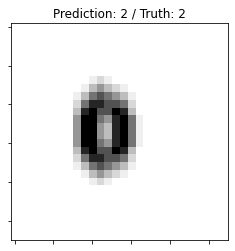

In [ ]:
image, label, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, label, prediction)

#Prototype


## GCM

Epoch 1/20
375/375 [==============================] - 5s 13ms/step - loss: 2.1750 - accuracy: 0.1861 - val_loss: 1.9609 - val_accuracy: 0.2410
Epoch 2/20
375/375 [==============================] - 5s 12ms/step - loss: 1.7052 - accuracy: 0.3750 - val_loss: 2.0571 - val_accuracy: 0.2638
Epoch 3/20
375/375 [==============================] - 4s 12ms/step - loss: 1.5162 - accuracy: 0.4859 - val_loss: 1.9359 - val_accuracy: 0.2724
Epoch 4/20
375/375 [==============================] - 5s 12ms/step - loss: 1.3762 - accuracy: 0.5519 - val_loss: 1.8206 - val_accuracy: 0.3019
Epoch 5/20
375/375 [==============================] - 4s 12ms/step - loss: 1.2520 - accuracy: 0.6163 - val_loss: 1.8889 - val_accuracy: 0.3039
Epoch 6/20
375/375 [==============================] - 4s 12ms/step - loss: 1.1527 - accuracy: 0.6580 - val_loss: 1.6292 - val_accuracy: 0.3887
Epoch 7/20
375/375 [==============================] - 4s 12ms/step - loss: 1.0730 - accuracy: 0.6873 - val_loss: 1.7745 - val_accuracy: 0.3318

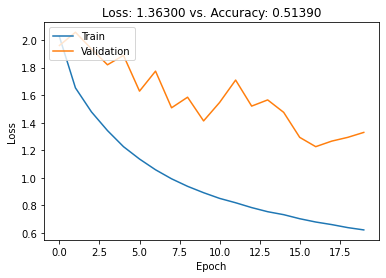

In [ ]:
geo_layers = get_cam_layers(keras.models.clone_model(model_geo))
mnist_layers = get_cam_layers(keras.models.clone_model(model_mnist))

model_gcm = keras.Sequential()

for layer in geo_layers[0]:
  layer.trainable = False
  model_gcm.add(layer)

model_gcm.add(layers.Dropout(0.3))
model_gcm.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
model_gcm.add(layers.GlobalAveragePooling2D())
model_gcm.add(layers.Dense(10, activation="softmax"))

# for layer in mnist_layers[1]:
  # model_gcm.add(layer)

opt = keras.optimizers.Adam(learning_rate=0.002)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=20, validation_split=0.2)
score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
model_gcm.summary()
plot_model_score(score_gcm, history_geocam.history)

##GEO-CAM

In [ ]:
# geo_layers = get_cam_layers(keras.models.clone_model(model_geo))
gcm_layers = get_cam_layers(keras.models.clone_model(model_gcm))

model_gcg = keras.Sequential()

for layer in geo_layers[1]:
  layer.trainable = False
  model_gcg.add(layer)

# model_gcg = Model([gcm_gap_layer.input], [gcm_gap_layer.output, model_gcm.output])

In [ ]:
def grad_cam_pp(image, model, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  heatmap_model = Model([model.inputs], [cam_layers[0][-1].get_output_at(0), model.output])

  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = heatmap_model(np.expand_dims(image, 0))
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, (conv_first_grad, conv_second_grad, conv_third_grad)

In [ ]:
def cam_1(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[1][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

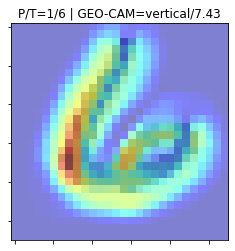

In [ ]:
# 1 - 3455
# 4 - 6195
# 0 - 3710
# 6 - 6187
# 7 - 6606
# 5 - 6148
# 9 - 5622
test_img_idx = 6187

# GCM
gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_img_idx)
gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_grads = grad_cam_pp(gcm_mnist_image, model_gcm, gcm_prediction_idx)

# GCG
gcg_prediction_idx = 2#np.argmax(model_gcg(gcm_conv_output))
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, gcg_prediction_idx)
gcg_mnist_cam_max = np.max(gcg_mnist_cam)

geo_labels = ["vertical", "diagonal", "ellipse"]
title = "P/T=%i/%i | GEO-CAM=%s/%.2f" % (gcm_prediction_idx, np.argmax(mnist_test[1][test_img_idx]), geo_labels[gcg_prediction_idx], gcg_mnist_cam_max)
show_heatmap(gcm_mnist_image, gcg_mnist_cam, (28, 28, 1), True, title)